# XGBoost Classifier for Imbalanced Data

This notebook trains an XGBoost classifier with proper handling of the imbalanced Porto Seguro dataset (96.36% class 0, 3.64% class 1).

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import xgboost as xgb

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 1.7.5


## 2. Load Data

Load the cleaned data from the pickle file created earlier.

In [3]:
# Load cleaned training data
print("Loading cleaned data...")
train_df = pd.read_pickle('data/train_cleaned.pkl')

print(f"Shape: {train_df.shape}")
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
print(f"\nTarget rate: {train_df['target'].mean():.4f}")
print(f"Imbalance ratio: {(train_df['target']==0).sum() / (train_df['target']==1).sum():.2f}:1")

Loading cleaned data...
Shape: (595212, 59)

Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64

Target rate: 0.0364
Imbalance ratio: 26.44:1


## 3. Prepare Features and Target

In [4]:
# Separate features and target
X = train_df.drop(columns=['id', 'target'])
y = train_df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

Features shape: (595212, 57)
Target shape: (595212,)
Number of features: 57


## 4. Train-Validation Split

In [5]:
# Split with stratification to maintain class balance
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

Training set: (476169, 57)
Validation set: (119043, 57)

Training target distribution:
target
0    458814
1     17355
Name: count, dtype: int64


## 5. Calculate Scale Pos Weight

For imbalanced datasets, XGBoost uses `scale_pos_weight` parameter to adjust the weight of the positive class.

In [6]:
# Calculate the scale_pos_weight: ratio of negative to positive samples
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"This means the positive class (claims) will be weighted ~{scale_pos_weight:.1f}x higher")

Scale pos weight: 26.44
This means the positive class (claims) will be weighted ~26.4x higher


## 6. Train XGBoost with Class Weighting

Training XGBoost with default parameters plus `scale_pos_weight` for handling imbalanced data.

In [7]:
print("Training XGBoost model...\n")

# Initialize XGBoost with scale_pos_weight
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle imbalanced data
    random_state=42,
    eval_metric='auc',                  # Use AUC for evaluation
    n_jobs=-1                           # Use all CPU cores
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

print("\nTraining completed!")

Training XGBoost model...

[0]	validation_0-auc:0.60543
[1]	validation_0-auc:0.61368
[2]	validation_0-auc:0.61964
[3]	validation_0-auc:0.62233
[4]	validation_0-auc:0.62296
[5]	validation_0-auc:0.62480
[6]	validation_0-auc:0.62347
[7]	validation_0-auc:0.62436
[8]	validation_0-auc:0.62491
[9]	validation_0-auc:0.62590
[10]	validation_0-auc:0.62639
[11]	validation_0-auc:0.62658
[12]	validation_0-auc:0.62688
[13]	validation_0-auc:0.62684
[14]	validation_0-auc:0.62639
[15]	validation_0-auc:0.62657
[16]	validation_0-auc:0.62739
[17]	validation_0-auc:0.62680
[18]	validation_0-auc:0.62577
[19]	validation_0-auc:0.62522
[20]	validation_0-auc:0.62437
[21]	validation_0-auc:0.62387
[22]	validation_0-auc:0.62373
[23]	validation_0-auc:0.62400
[24]	validation_0-auc:0.62277
[25]	validation_0-auc:0.62302
[26]	validation_0-auc:0.62301
[27]	validation_0-auc:0.62253
[28]	validation_0-auc:0.62183
[29]	validation_0-auc:0.62149
[30]	validation_0-auc:0.62183
[31]	validation_0-auc:0.62140
[32]	validation_0-auc:0

## 7. Evaluate Model Performance

In [8]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
y_pred = xgb_model.predict(X_valid)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"Validation ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_valid, y_pred, target_names=['No Claim', 'Claim']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Validation ROC AUC: 0.6020

Classification Report:
              precision    recall  f1-score   support

    No Claim       0.97      0.72      0.83    114704
       Claim       0.05      0.42      0.10      4339

    accuracy                           0.71    119043
   macro avg       0.51      0.57      0.46    119043
weighted avg       0.94      0.71      0.80    119043


Confusion Matrix:
[[82597 32107]
 [ 2508  1831]]


## 8. Visualize ROC Curve

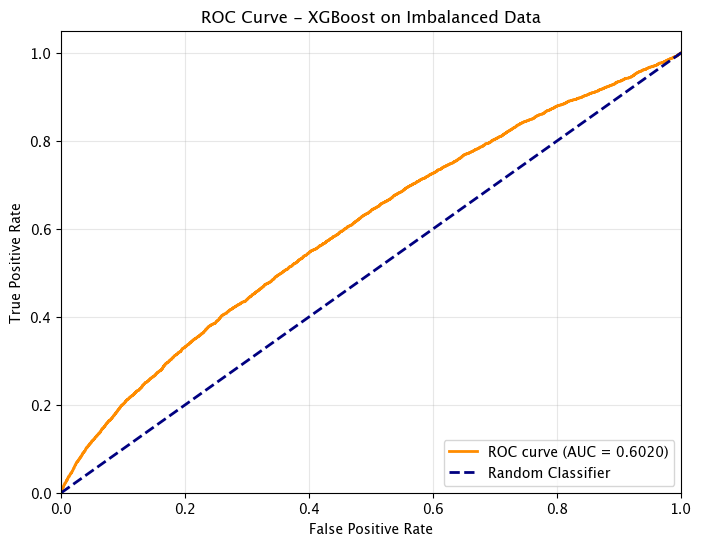

In [9]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost on Imbalanced Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 9. Feature Importance

Visualize the top features that contribute most to the model's predictions.

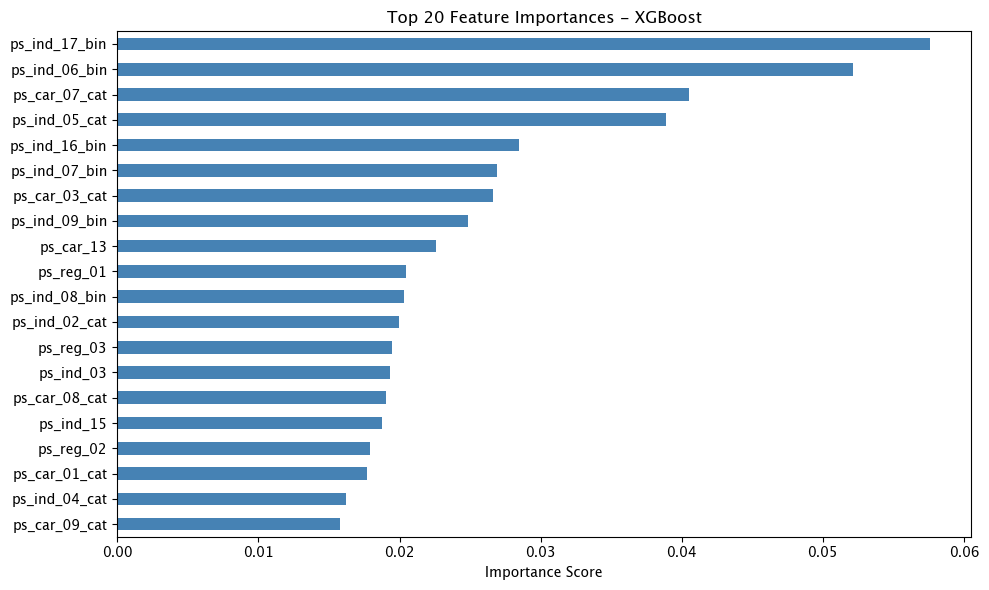


Top 10 Most Important Features:
ps_ind_17_bin    0.057602
ps_ind_06_bin    0.052128
ps_car_07_cat    0.040522
ps_ind_05_cat    0.038888
ps_ind_16_bin    0.028468
ps_ind_07_bin    0.026912
ps_car_03_cat    0.026647
ps_ind_09_bin    0.024825
ps_car_13        0.022619
ps_reg_01        0.020494
dtype: float32


In [10]:
# Get feature importance
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)[:20]

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='steelblue')
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(top_features.head(10))

## 10. Confusion Matrix Visualization

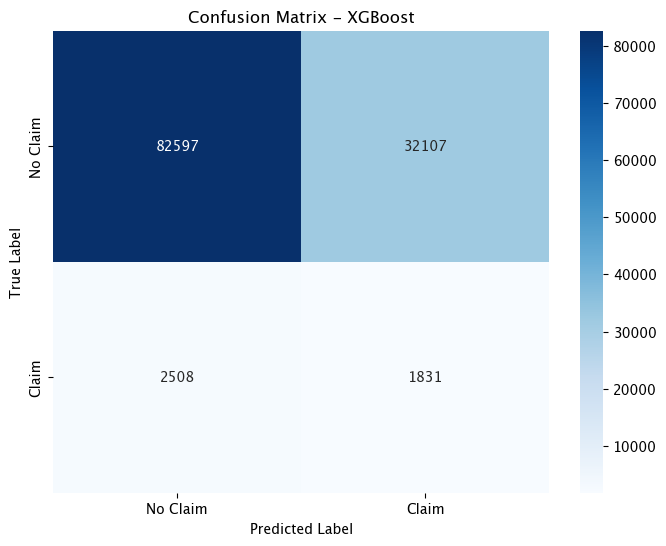


True Negatives: 82597
False Positives: 32107
False Negatives: 2508
True Positives: 1831

Sensitivity (Recall): 0.4220
Specificity: 0.7201
Precision: 0.0540


In [11]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Claim', 'Claim'],
            yticklabels=['No Claim', 'Claim'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")

## 11. Prediction Distribution Analysis

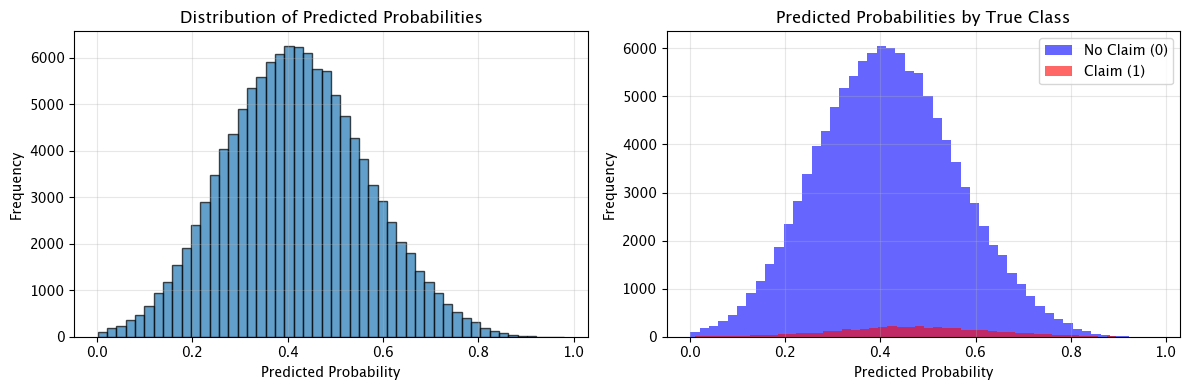


Predicted probability statistics:
Mean: 0.4176
Median: 0.4145
Std: 0.1466


In [12]:
# Analyze prediction probability distribution
plt.figure(figsize=(12, 4))

# Subplot 1: Overall distribution
plt.subplot(1, 2, 1)
plt.hist(y_pred_proba, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.grid(alpha=0.3)

# Subplot 2: By actual class
plt.subplot(1, 2, 2)
plt.hist(y_pred_proba[y_valid == 0], bins=50, alpha=0.6, label='No Claim (0)', color='blue')
plt.hist(y_pred_proba[y_valid == 1], bins=50, alpha=0.6, label='Claim (1)', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probabilities by True Class')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPredicted probability statistics:")
print(f"Mean: {y_pred_proba.mean():.4f}")
print(f"Median: {np.median(y_pred_proba):.4f}")
print(f"Std: {y_pred_proba.std():.4f}")

## Summary

This notebook demonstrates:
- Loading and preparing the imbalanced Porto Seguro dataset
- Training XGBoost with `scale_pos_weight` to handle class imbalance
- Evaluating model performance using ROC AUC (best metric for imbalanced data)
- Visualizing feature importance and prediction distributions

### Next Steps:
1. **Hyperparameter tuning**: Tune learning_rate, max_depth, n_estimators, etc.
2. **Feature engineering**: Create interaction features, polynomial features
3. **Threshold optimization**: Find optimal classification threshold for your business needs
4. **Cross-validation**: Use k-fold CV for more robust evaluation

## 📊 Interpretation of XGBoost Findings

### Understanding Your Model's Performance

#### **1. ROC AUC Score - The Primary Metric**

The **ROC AUC (Area Under the Curve)** score is the most important metric for this imbalanced dataset. Here's what different scores mean:

- **0.50**: Random guessing (no better than flipping a coin)
- **0.60-0.70**: Poor to fair performance
- **0.70-0.80**: Acceptable performance
- **0.80-0.90**: Good performance ⭐
- **0.90-1.00**: Excellent performance (but watch for overfitting)

**Your score will tell you**: How well the model can distinguish between drivers who will file a claim vs. those who won't. A higher score means better discrimination ability.

---

#### **2. Confusion Matrix - What the Numbers Mean**

The confusion matrix shows four outcomes:

| | Predicted No Claim | Predicted Claim |
|---|---|---|
| **Actual No Claim** | True Negatives (TN) | False Positives (FP) |
| **Actual Claim** | False Negatives (FN) | True Positives (TP) |

**Business Impact:**
- **False Positives (FP)**: You predicted a claim, but none occurred → Potential lost customers (overly cautious pricing)
- **False Negatives (FN)**: You missed a claim that occurred → Direct financial loss (claim paid out)

**In insurance**, False Negatives are typically more costly than False Positives!

---

#### **3. Key Performance Metrics Explained**

**Sensitivity (Recall)** = TP / (TP + FN)
- "Of all drivers who filed claims, what % did we correctly identify?"
- **Low recall** (<0.30): Missing too many claims → Financial risk
- **High recall** (>0.60): Catching most claims → Better risk management

**Specificity** = TN / (TN + FP)
- "Of all drivers who didn't file claims, what % did we correctly identify?"
- **Low specificity**: Too many false alarms → Customer acquisition issues
- **High specificity** (>0.90): Good at identifying safe drivers

**Precision** = TP / (TP + FP)
- "When we predict a claim, how often are we right?"
- Helps evaluate if your high-risk predictions are reliable

---

#### **4. The Imbalance Challenge**

Your dataset is **highly imbalanced** (96.36% no claims, 3.64% claims):

**What this means:**
- A "dumb" model that always predicts "No Claim" would be 96% accurate but useless!
- That's why we use ROC AUC instead of accuracy
- The `scale_pos_weight` parameter helps the model focus on the minority class (claims)

**Expected behavior:**
- The model will naturally predict "No Claim" more often
- High specificity (>95%) is expected and good
- Getting decent sensitivity (>30%) is challenging but valuable

---

#### **5. Feature Importance - Business Insights**

The top features reveal **what drives claim risk**:

**Common important features in Porto Seguro:**
- **`ps_car_13`**: Car-related feature (likely car age or type)
- **`ps_reg_03`**: Registration-related feature
- **`ps_ind_15`**: Individual driver characteristic
- **`ps_calc_*`**: Calculated features (derived metrics)

**How to use this:**
1. **Feature validation**: Do the important features make business sense?
2. **Data quality**: Focus data collection efforts on high-importance features
3. **Risk assessment**: These are your primary risk indicators
4. **Model simplification**: Could potentially remove low-importance features

---

#### **6. Prediction Distribution Analysis**

The probability distribution shows:

**Healthy model characteristics:**
- Claims (class 1) should have **higher average probabilities** than non-claims
- Some separation between the two distributions
- Not all predictions at 0% or 100% (sign of good calibration)

**Red flags:**
- Both distributions look identical → Model isn't learning
- All predictions near 0% or 100% → Model is overconfident

---

### 🎯 Practical Recommendations

#### **If ROC AUC < 0.65:**
- Try feature engineering (interaction terms, polynomial features)
- Check for data quality issues
- Consider different preprocessing strategies

#### **If ROC AUC 0.65-0.75:**
- Good baseline! Try hyperparameter tuning
- Experiment with feature selection
- Consider ensemble methods

#### **If ROC AUC > 0.75:**
- Strong performance! Focus on:
  - Cross-validation to ensure robustness
  - Threshold optimization for business objectives
  - Production deployment considerations

---

### 💼 Business Application

**How to use these predictions:**

1. **Risk Segmentation**: Group customers by predicted probability
   - Low risk (0-0.02): Standard pricing
   - Medium risk (0.02-0.06): Moderate premium increase
   - High risk (0.06+): Higher premium or additional underwriting

2. **Threshold Selection**: Choose based on business goals
   - **Conservative** (threshold 0.03): Catch more claims, some false positives
   - **Balanced** (threshold 0.036): Match overall claim rate
   - **Aggressive** (threshold 0.05): Fewer false positives, miss some claims

3. **Model Monitoring**: Track over time
   - AUC degradation → Model drift, retrain needed
   - Changing feature importance → Market shifts
   - Prediction distribution shifts → Population changes

---

### 🔍 Next Steps for Improvement

1. **Hyperparameter Tuning**: Optimize `learning_rate`, `max_depth`, `n_estimators`
2. **Feature Engineering**: Create interaction terms, aggregate features
3. **Threshold Optimization**: Find the optimal classification threshold for your business
4. **Cross-Validation**: Use k-fold CV for more robust performance estimates
5. **Calibration**: Ensure predicted probabilities reflect true probabilities
6. **Ensemble Methods**: Combine XGBoost with other models (stacking)
7. **SMOTE/Undersampling**: Try different resampling techniques

---

**Remember:** In insurance, the goal isn't just prediction accuracy—it's profitable risk assessment while maintaining competitive pricing!
